##**Notebook PC#09 - Part 1**
## Autoencoder training and manifold visualization for the MNIST database.
## Partially based on [this material](https://www.kaggle.com/apapiu/manifold-learning-and-autoencoders).

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Beatriz Akiria de Assis Quaresma - 203899 <br>
**Aluno(a):** Decio Miranda Filho - 236087

### Loading the main libraries

In [ ]:
import tensorflow as tf
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from keras.utils import to_categorical

### Reading the data

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
x_images = x_train.reshape(x_train.shape[0], 28, 28)

In [ ]:
# Definition of a function to visualize some digits
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

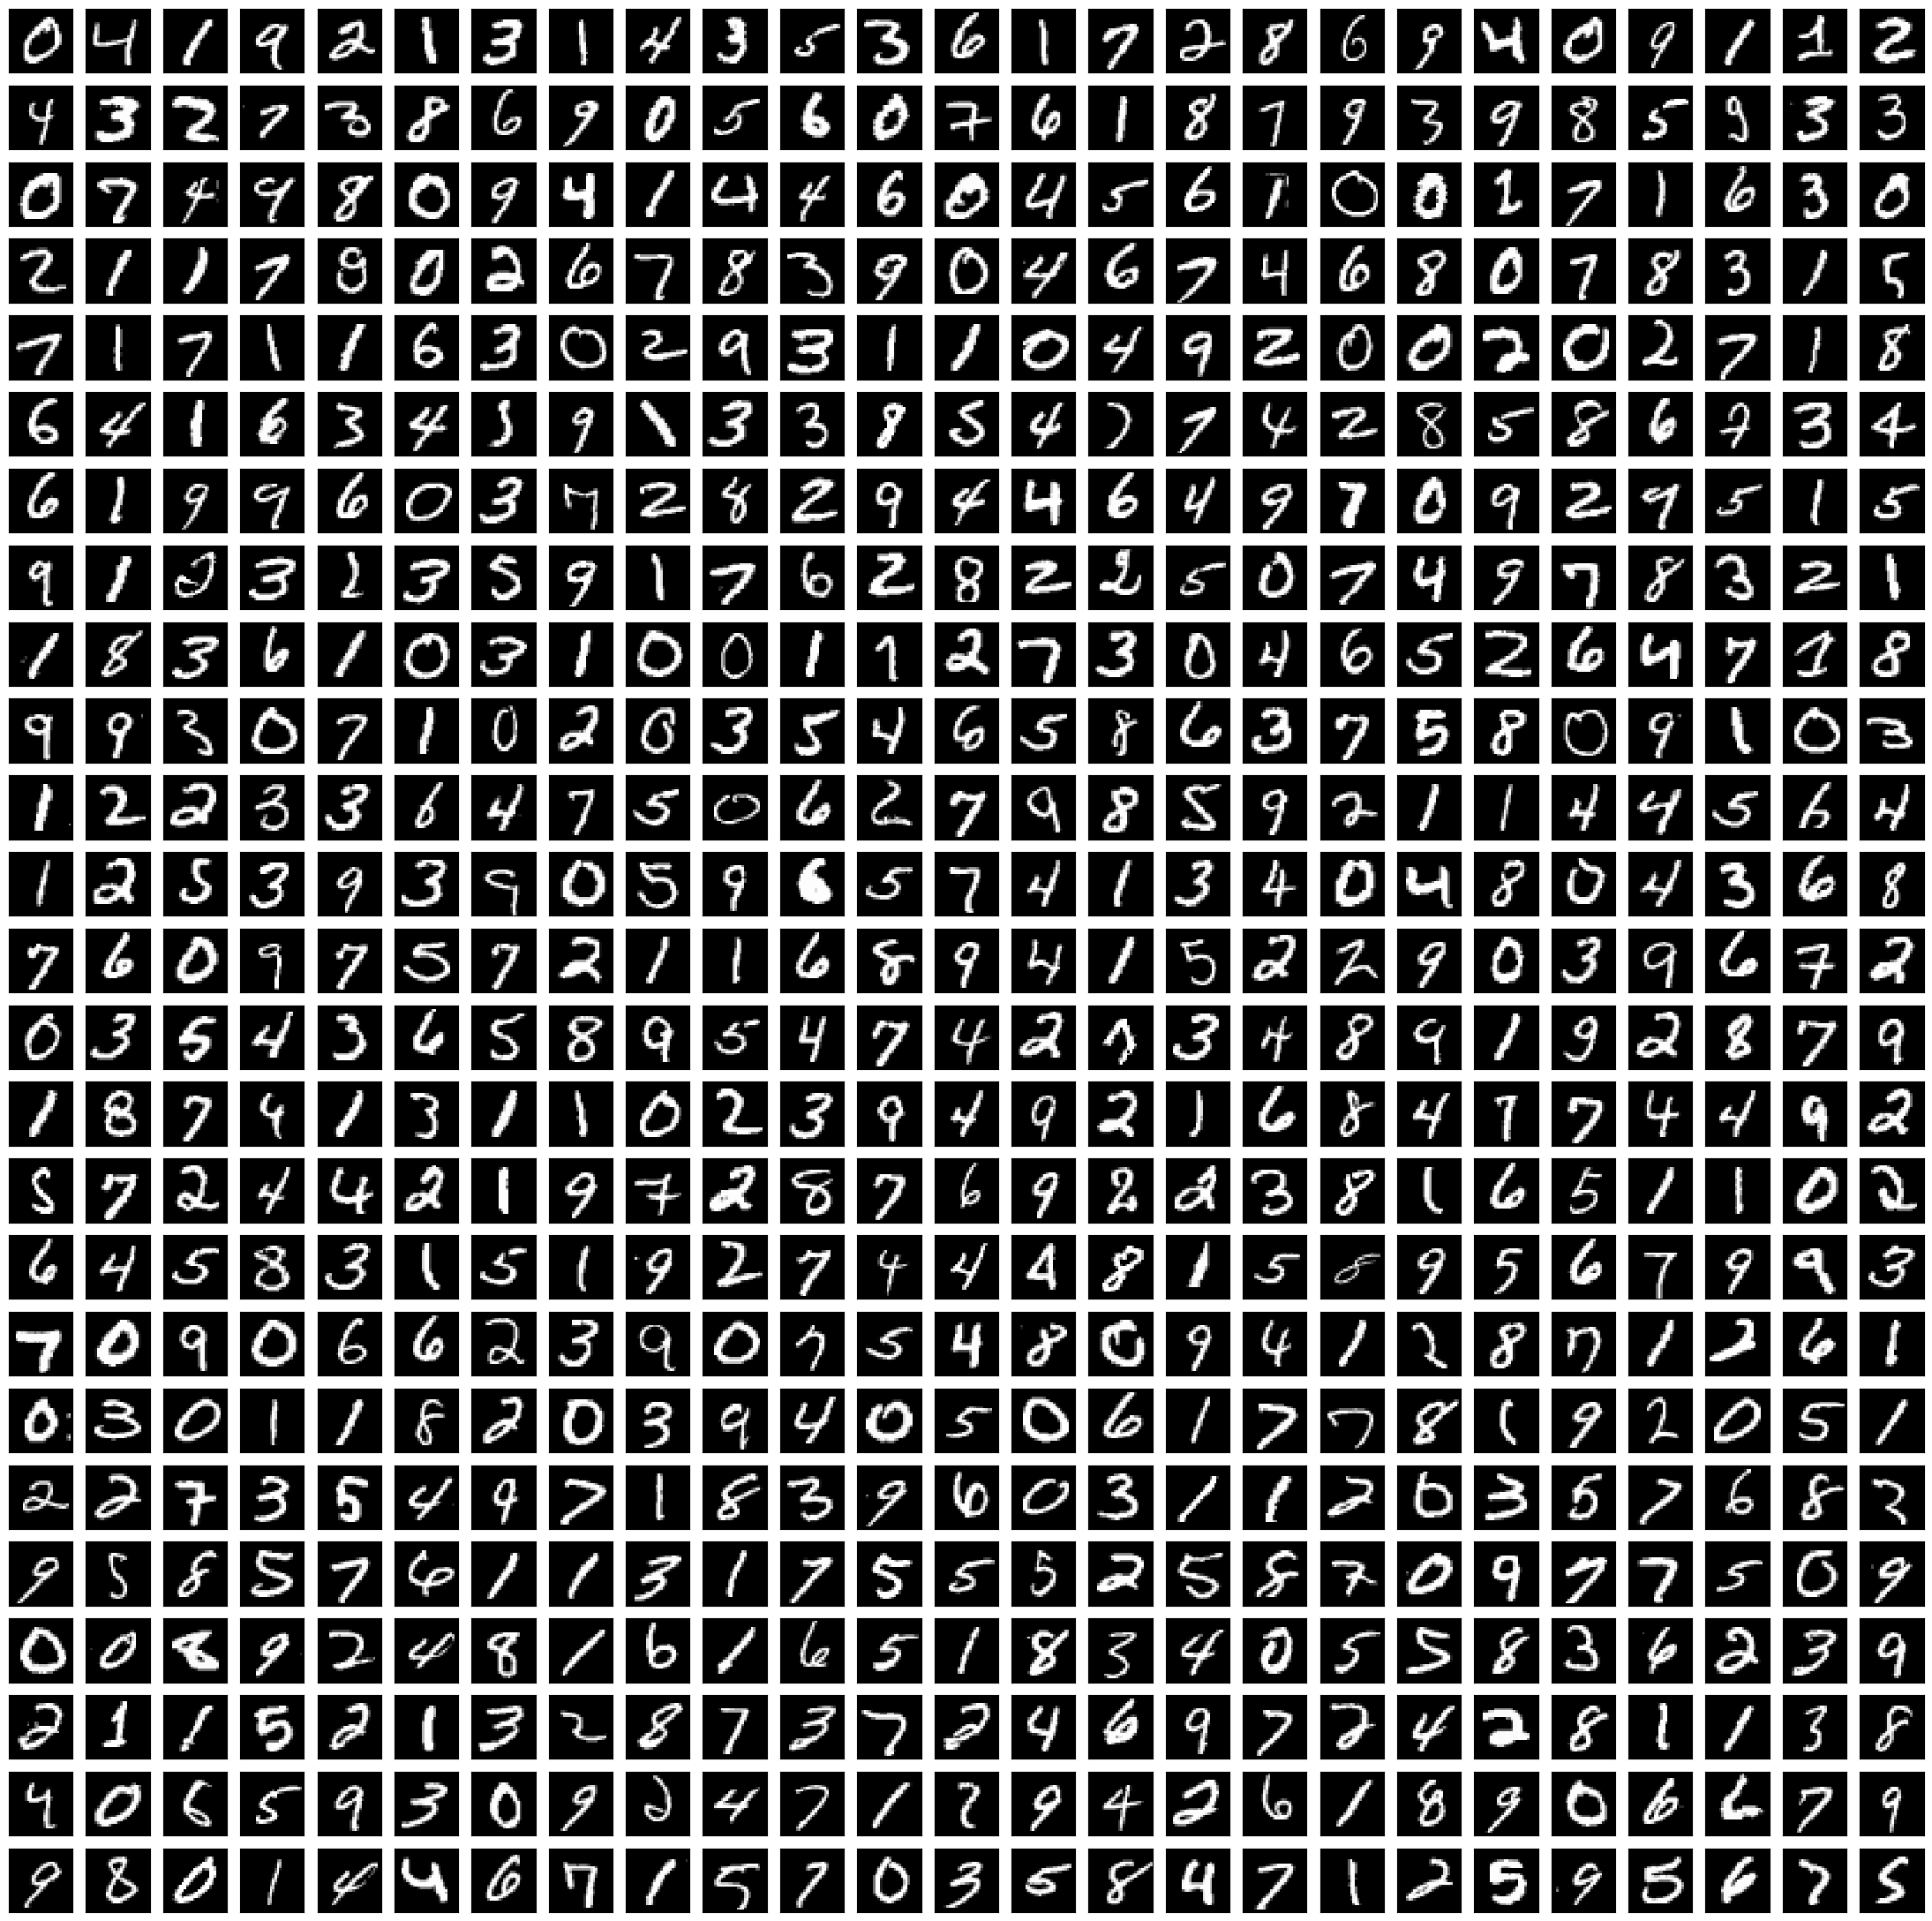

In [ ]:
# Visualization of 25 x 25 original images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(x_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

### Proposal for the autoencoder architecture

In [ ]:
input_img = Input(shape=(784,))

encoded = Dense(512, activation='tanh')(input_img)
encoded = Dense(128, activation='tanh')(encoded)
encoded = Dense(32, activation='tanh')(encoded)

encoded = Dense(2)(encoded) # Linear activation function at the bottleneck

decoded = Dense(32, activation='tanh')(encoded)
decoded = Dense(128, activation='tanh')(decoded)
decoded = Dense(512, activation='tanh')(decoded)

decoded = Dense(784, activation = 'sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
 dense_4 (Dense)             (None, 32)                96        
                                                                 
 dense_5 (Dense)             (None, 128)               4224  

In [ ]:
autoencoder.compile(optimizer = "adam", loss = "mse")
X = x_train.reshape(x_train.shape[0], 784)
history = autoencoder.fit(X, X, batch_size = 128, epochs = 50, verbose = 1)

Epoch 1/50
469/469 [==============================] - 7s 5ms/step - loss: 0.0615
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0482
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0438
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0415
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0401
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0391
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0384
Epoch 8/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0377
Epoch 9/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0372
Epoch 10/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0368
Epoch 11/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0364
Epoch 12/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0360
Epoch 13/50
469/469 [====

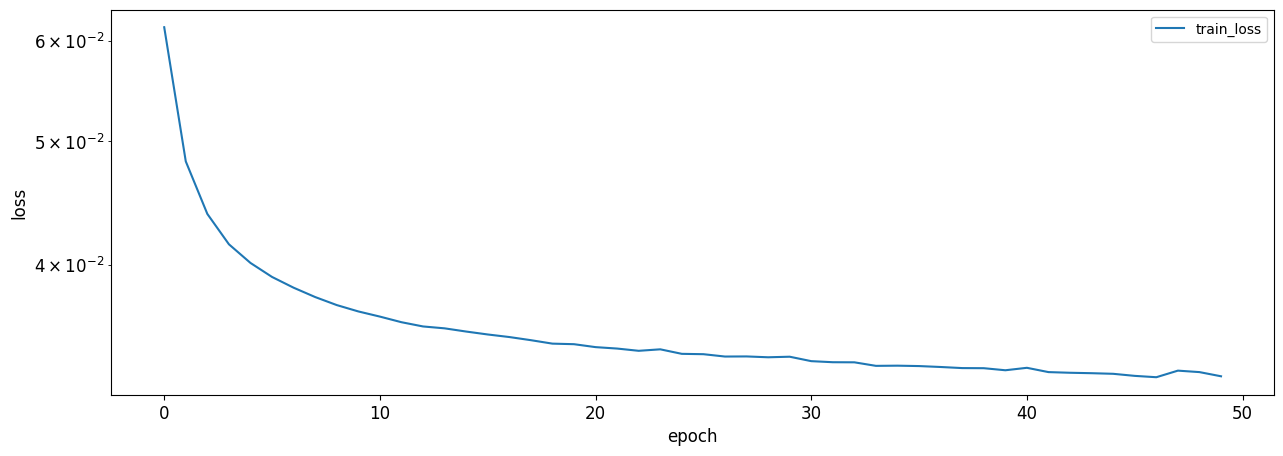

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

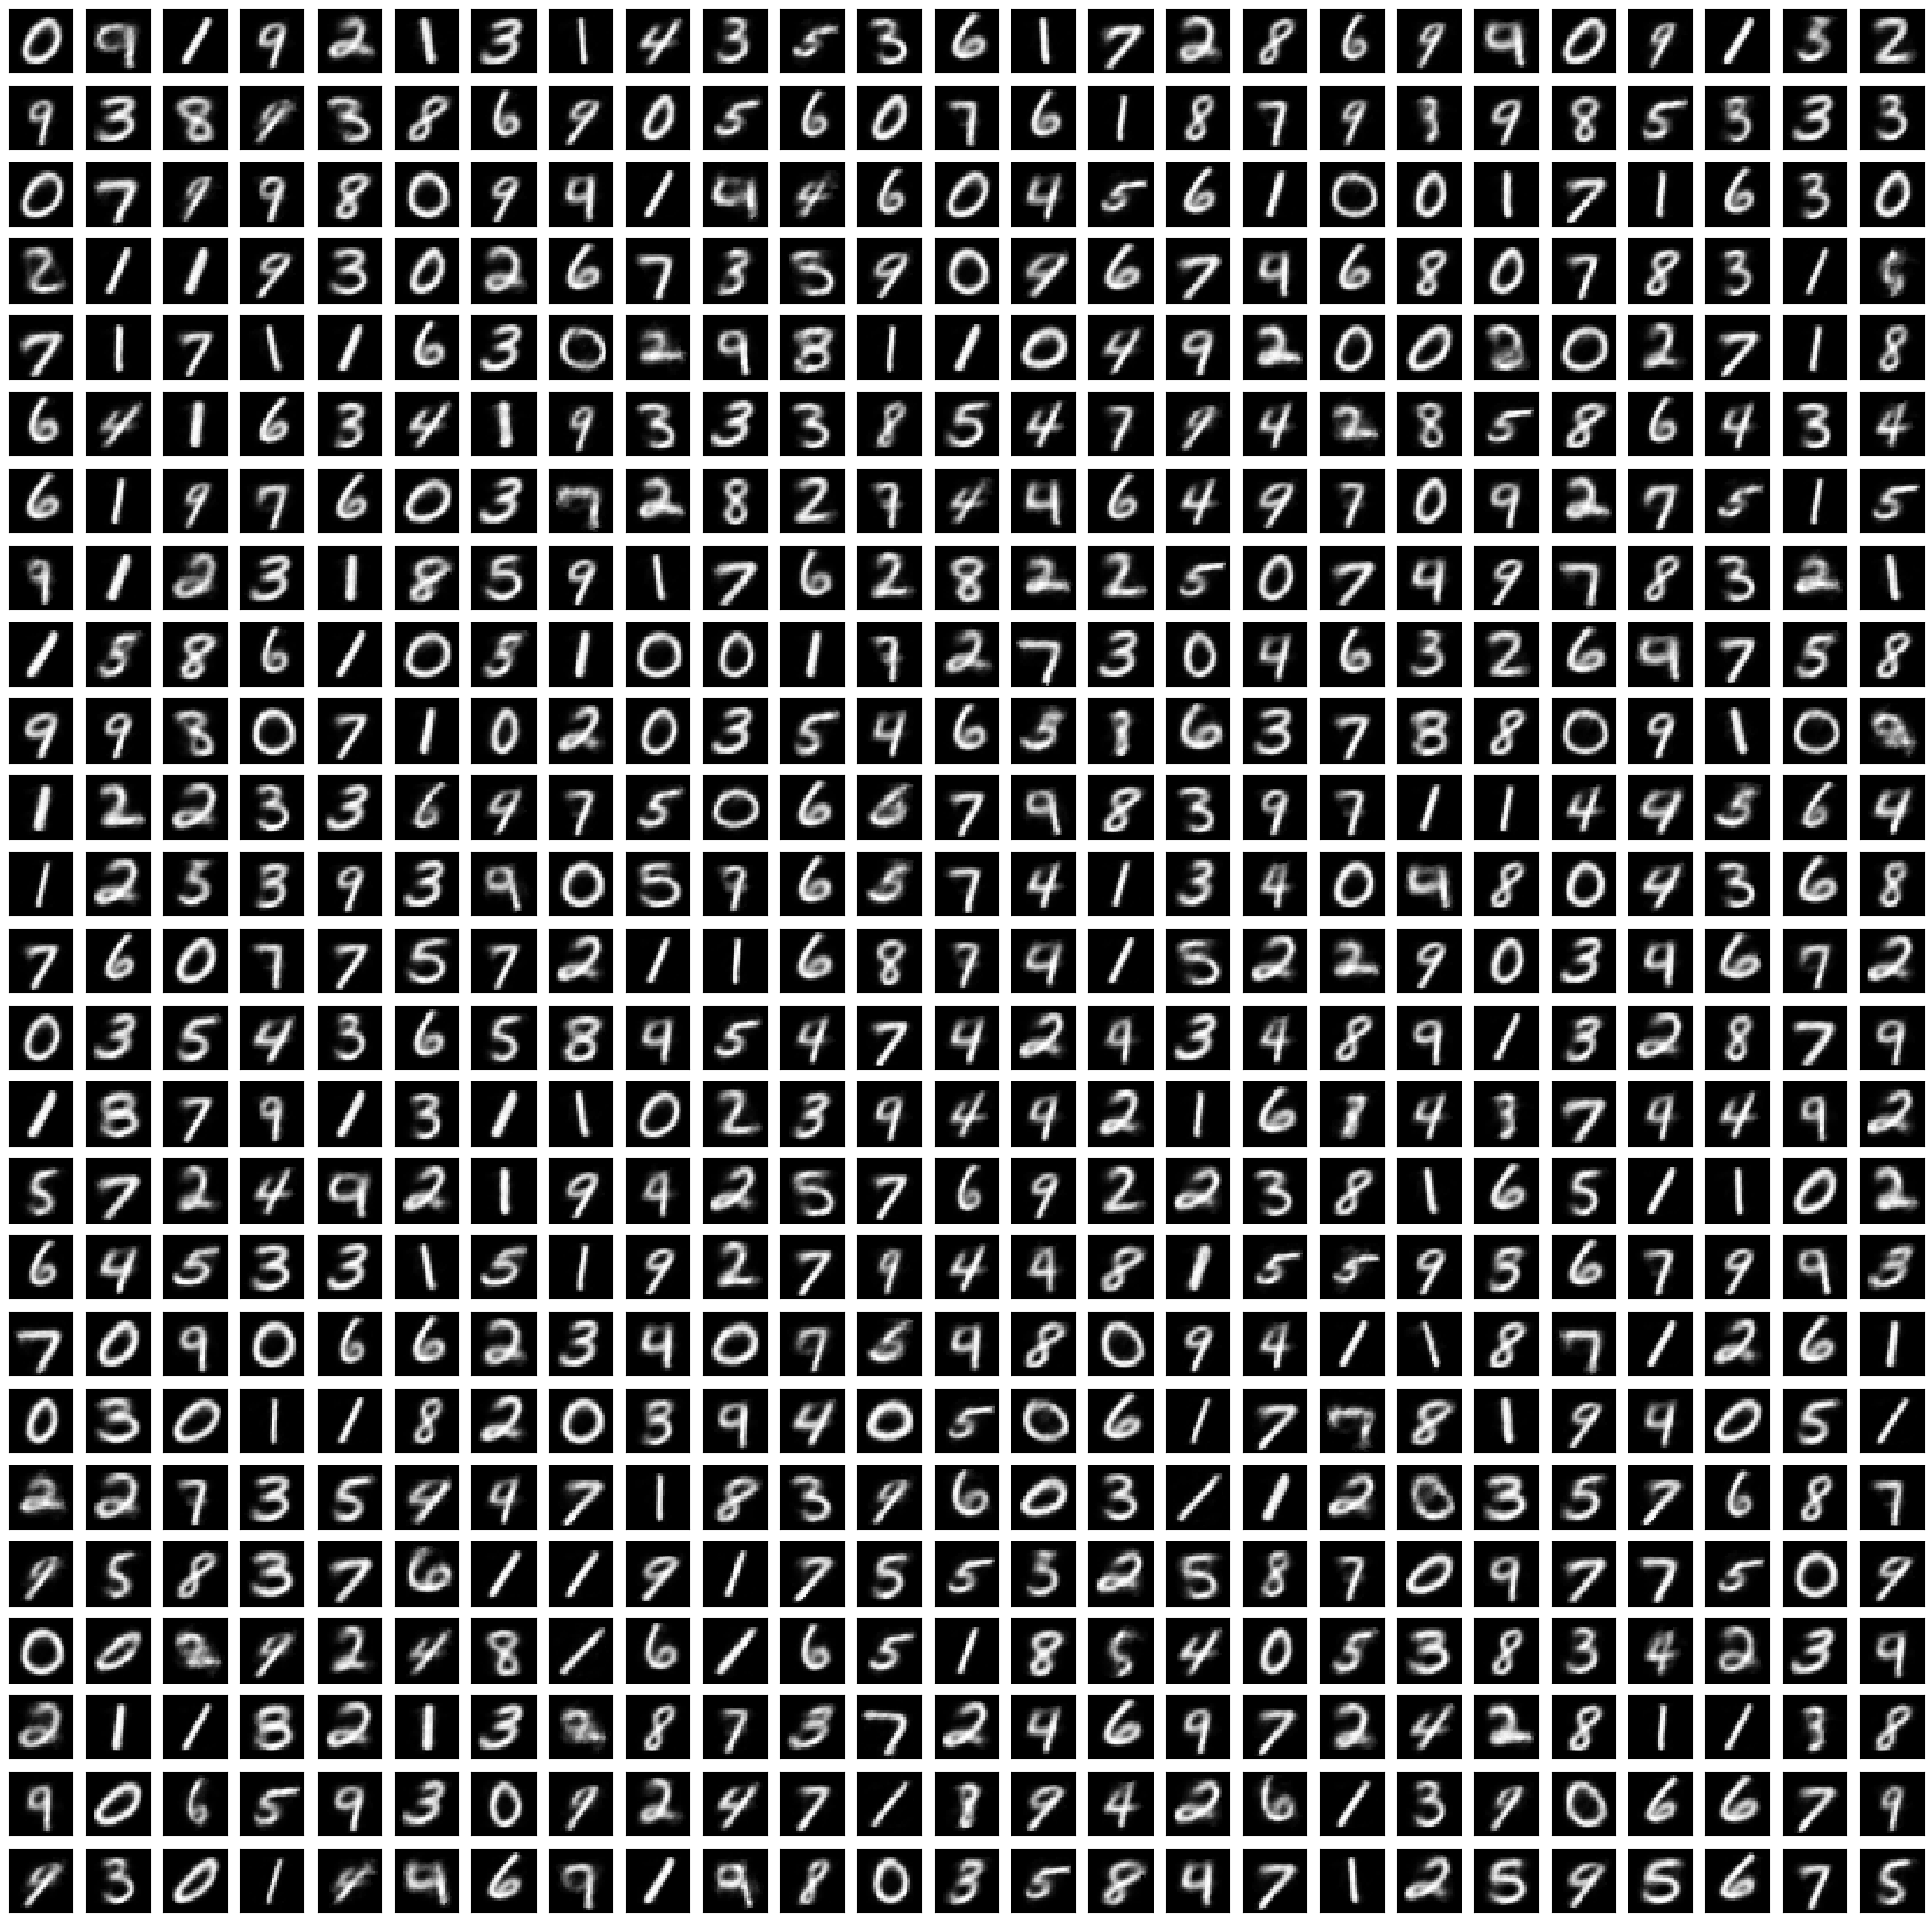

In [ ]:
# Visualization of 25 x 25 reconstructed images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(autoencoder.predict(np.expand_dims(x_images[ind].flatten(), 0), verbose = False).reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        ind+=1

In [ ]:
encoder = Model(input_img, encoded)

# Building the decoder
encoded_input = Input(shape=(2,))
encoded_layer_1 = autoencoder.layers[-4]
encoded_layer_2 = autoencoder.layers[-3]
encoded_layer_3 = autoencoder.layers[-2]
encoded_layer_4 = autoencoder.layers[-1]

decoder = encoded_layer_1(encoded_input)
decoder = encoded_layer_2(decoder)
decoder = encoded_layer_3(decoder)
decoder = encoded_layer_4(decoder)
decoder = Model(encoded_input, decoder)

### Visualizing the images in the manifold

1875/1875 [==============================] - 3s 1ms/step


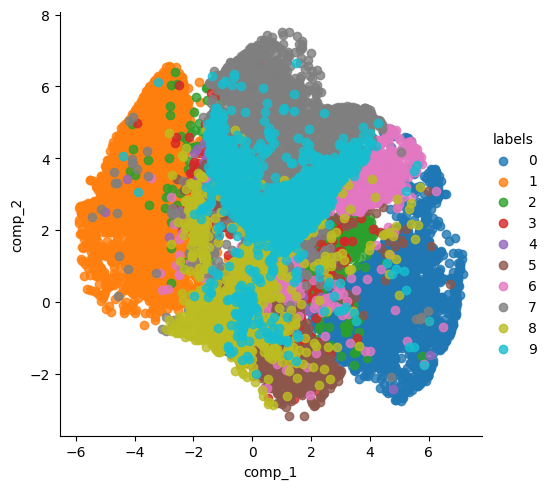

In [ ]:
# Using encoder to visualize the manifold

import seaborn as sns

x_flat = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])

x_proj = encoder.predict(x_flat[:60000])
x_proj.shape

proj = pd.DataFrame(x_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train[:60000]
sns.lmplot(x = "comp_1", y = "comp_2", hue="labels", data=proj, fit_reg=False, logx = True)

### Generating new digits by moving along the manifold (latent 2D space)
**Please, adjust the scale whenever necessary.**

### Moving along a circle

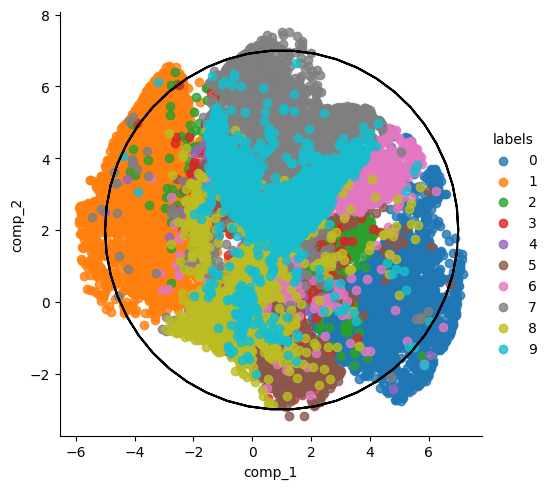

In [ ]:
_ = sns.lmplot(x = "comp_1", y = "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [6 * np.cos(4 * np.pi / 100 * i) + 1 for i in range(100)] #Estava cos(2*) e sen(2*)
all_y = [5 * np.sin(4 * np.pi / 100 * i) + 2 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

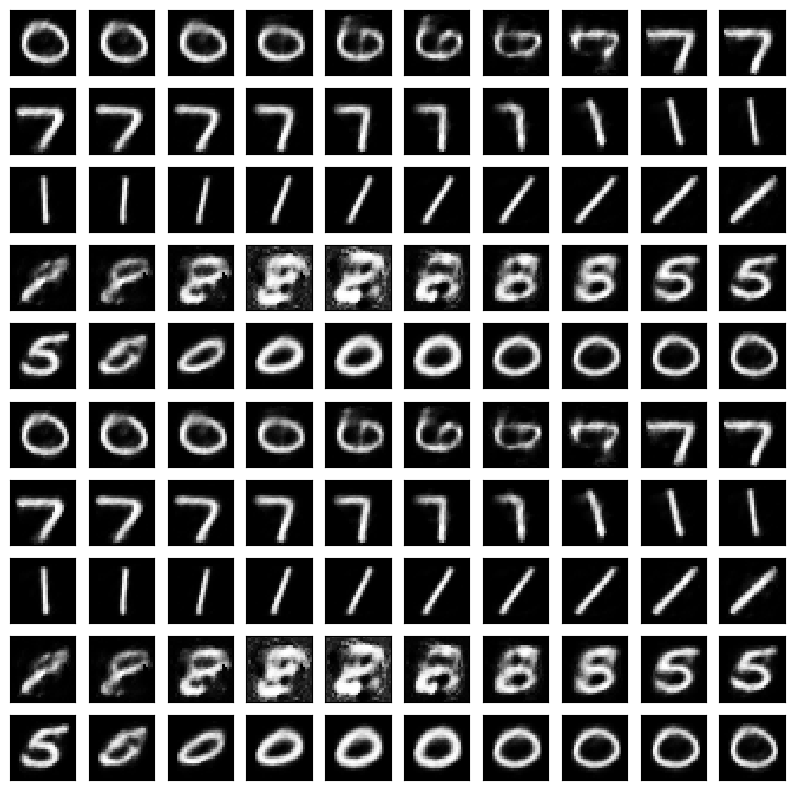

In [ ]:
# moving along a circle:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)

    x = 6 * np.cos(4 * np.pi / 100 * i) + 1
    y = 5 * np.sin(4 * np.pi / 100 * i) + 2

    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt, verbose = False).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### Moving along an ellipse

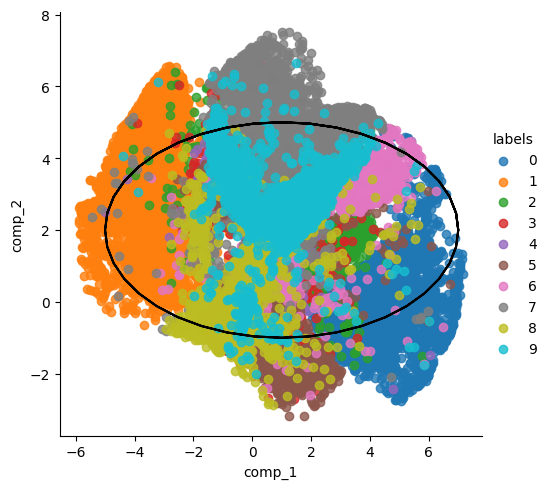

In [ ]:
_ = sns.lmplot(x = "comp_1", y = "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [6 * np.cos(5 * np.pi / 100 * i) + 1 for i in range(100)]
all_y = [3 * np.sin(5 * np.pi / 100 * i) +2 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

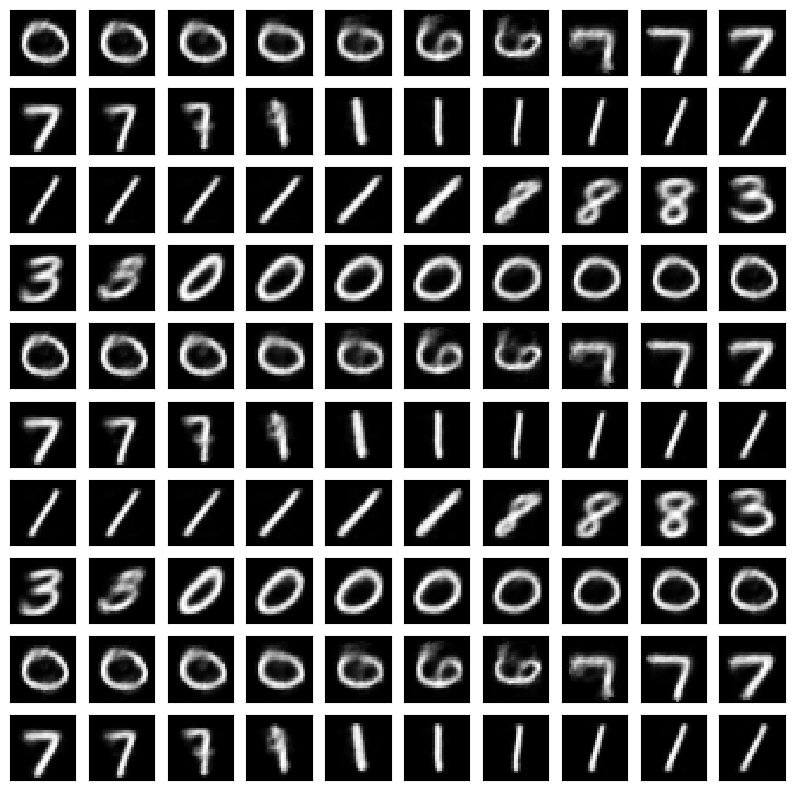

In [ ]:
# Moving along an ellipse:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)

    x = 6 * np.cos(5 * np.pi / 100 * i) + 1
    y = 3 * np.sin(5 * np.pi / 100 * i) + 2

    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt, verbose = False).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### Moving along a grid

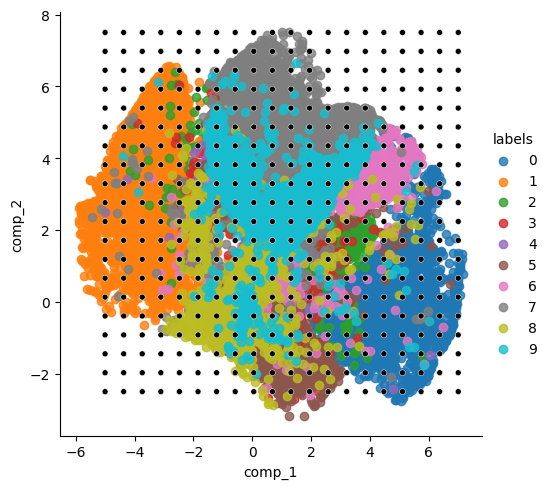

In [ ]:
pt_x = []
pt_y = []
for i in range(20):
    for j in range(20):
        pt_x.append(-5 + 12 * i / 19)
        pt_y.append(-2.5 + 10 * j / 19)
_ = sns.lmplot(x = "comp_1", y = "comp_2", hue="labels", data=proj, fit_reg=False)
_ = sns.scatterplot(x = pt_x,y = pt_y, color = 'black', size = 0.5, legend = False )

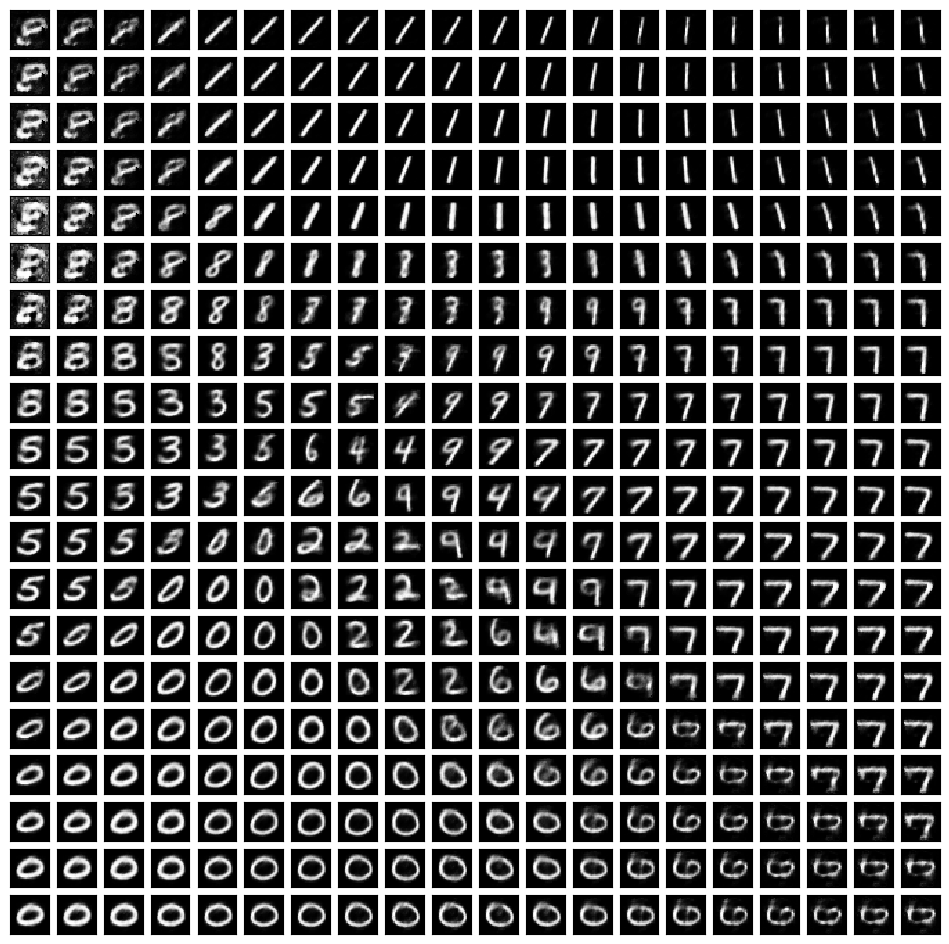

In [ ]:
# Moving along a grid:
_ = plt.figure(figsize=(12, 12))

for i in range(20):
    for j in range(20):

        _ = plt.subplot(20, 20, i * 20 + j + 1)

        pt = np.array([[ -5 + 12 * i / 19, -2.5 + 10 * j / 19]])
        _ = show(decoder.predict(pt, verbose = False).reshape((28, 28)))
        _ = plt.xticks([])
        _ = plt.yticks([])